# Grover's Algorithm

Grover's algorithm takes an iterative approach: it evaluates $f$ on superpositions of input strings and intersperses these evaluations with other operations that have the effect of creating interference patterns, leading to a solution with high probability (if one exists) after $O(\sqrt{N})$ iterations.

In [67]:
import numpy as np
import math

from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate, XGate
from qiskit.visualization import plot_distribution

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler 

#### Phase Query Gates

The phase query gates are the key to Grover's algorithm. They are a sequence of two operations: the oracle $U_f$ and the inversion about the mean $U_s$. The oracle $U_f$ flips the sign of the target state $|x\rangle$ if $f(x) = 1$:

$$
Z_f|x\rangle = (-1)^{f(x)}|x\rangle
$$

In [68]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        qc.barrier()
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    qc.barrier()
    return qc

### Grover Operator

The computational basis state afte applying $H^{\otimes n}$ can be written as:

$$
|u\rangle = \frac{1}{\sqrt{N}}\sum_{x \in \{0,1\}^n}|x\rangle = \sqrt{\frac{|A_0|}{N}}|A_0\rangle + \sqrt{\frac{|A_1|}{N}}|A_1\rangle
$$

where $A_0$ is the set of non-solutions and $A_1$ is the set of solutions.

The Grover operator $G$ is defined as:

$$
G|A_0\rangle = \frac{|A_1\rangle - |A_0\rangle}{N}|A_0\rangle + 2\sqrt{\frac{|A_0|.|A_1|}{N}}|A_1\rangle
$$
$$
G|A_1\rangle = -2\sqrt{\frac{|A_0|.A_1}{N}}|A_0\rangle + \frac{|A_0\rangle - |A_1\rangle}{N}|A_1\rangle
$$

In matrix form, the Grover operator is:

$$
M = \begin{bmatrix}
\frac{|A_0\rangle - |A_1\rangle}{N}  & 2\sqrt{\frac{|A_0|.|A_1|}{N}} \\
-2\sqrt{\frac{|A_0|.A_1}{N}} & \frac{|A_0\rangle - |A_1\rangle}{N}
\end{bmatrix}
$$

In [69]:
def PhaseQueryOr(num_qubits):
  """Phase Query for OR function

  Args:
    num_qubits (int): number of qubits

  Returns:
    |X> if the input is |0> ^ n

    -|X> if the input is not |0> ^ n
  """

  qc = QuantumCircuit(num_qubits, name="Z_or")
  qc.barrier()
  qc.x(list(range(num_qubits)))
  qc.h(num_qubits - 1)
  qc.compose(MCMT(XGate(), num_qubits - 1, 1), inplace=True)
  qc.h(num_qubits - 1)
  qc.x(list(range(num_qubits)))
  qc.barrier()
  return qc

In [70]:
def CustomGroverOperator(oracle):
    """Build a custom Grover operator

    Parameters:
        oracle (QuantumCircuit): Quantum circuit representing Grover oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover operator

    Description:
        Can use .power() method to apply the operator multiple times
    """

    num_qubits = oracle.num_qubits
    qc = QuantumCircuit(num_qubits)
    qc.append(oracle.to_instruction(label="Z_f"), list(range(num_qubits)))
    qc.h(list(range(num_qubits)))
    qc.append(PhaseQueryOr(num_qubits).to_instruction(), list(range(num_qubits)))
    qc.h(list(range(num_qubits)))
    return qc

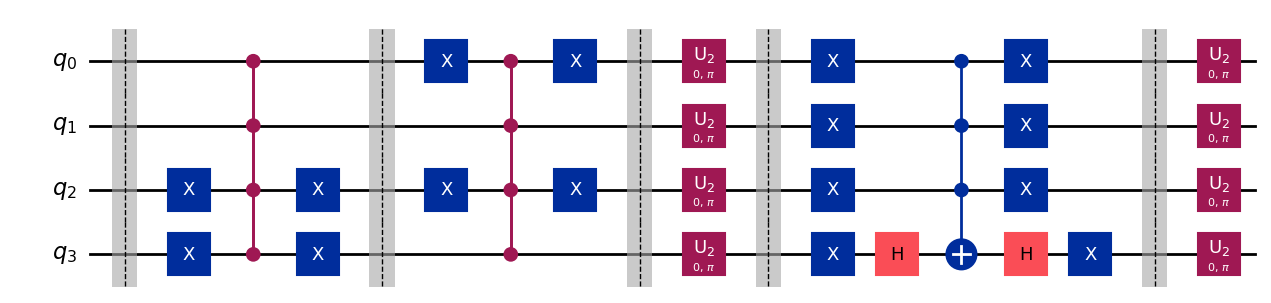

In [71]:
marked_states = ["0011", "1010"]
oracle = grover_oracle(marked_states)
grover_op = CustomGroverOperator(oracle)
grover_op.decompose().draw(output='mpl', style='iqp')

#### Optimal No. of iterations

The optimal number of iterations is given by:

$$
t = \left \lfloor \frac{\pi}{4\theta} \right \rfloor
$$

where $\theta = \arcsin \left(\sqrt{\frac{|A_1|}{N}}\right)$.

In [72]:
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
)
print(f"Optimal number of iterations: {optimal_num_iterations}")

Optimal number of iterations: 2


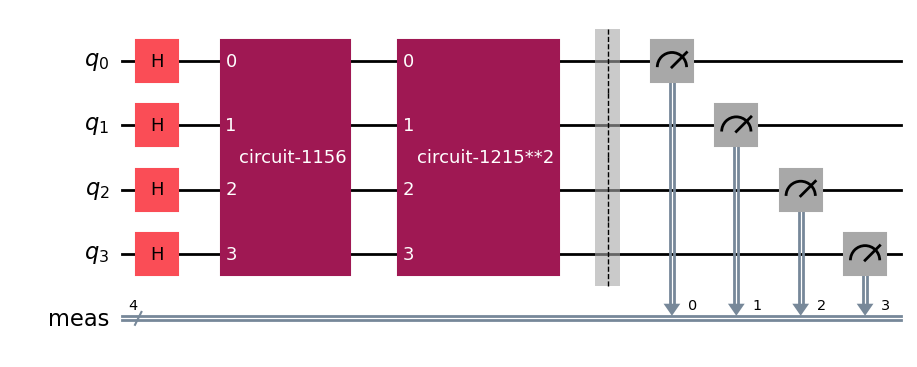

In [73]:
circuit = QuantumCircuit(grover_op.num_qubits)
circuit.h(list(range(grover_op.num_qubits)))
circuit.append(oracle, list(range(grover_op.num_qubits)))
circuit.append(grover_op.power(optimal_num_iterations), list(range(grover_op.num_qubits)))

circuit.measure_all()
circuit.draw(output='mpl', style='iqp')

In [74]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=AerSimulator(), optimization_level=3)

circuit_isa = pm.run(circuit)
# circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [75]:
sampler = Sampler(backend=AerSimulator())
sampler.options.default_shots = 10_000
result = sampler.run([circuit_isa]).result()
dist = result[0].data.meas.get_counts()

/tmp/ipykernel_342526/653221614.py:1: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  sampler = Sampler(backend=AerSimulator())


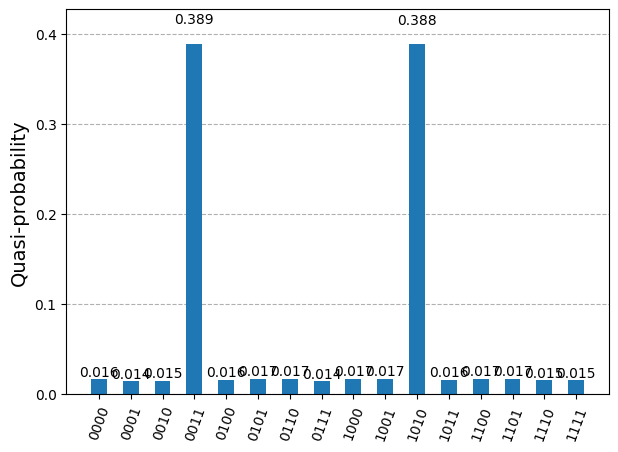

In [76]:
plot_distribution(dist)

### Using Library

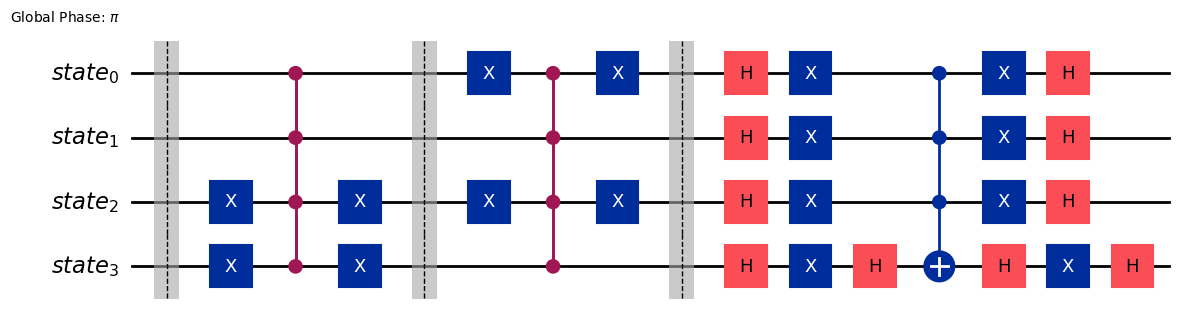

In [77]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output='mpl', style='iqp')

/tmp/ipykernel_342526/1833042420.py:12: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  sampler = Sampler(backend=AerSimulator())


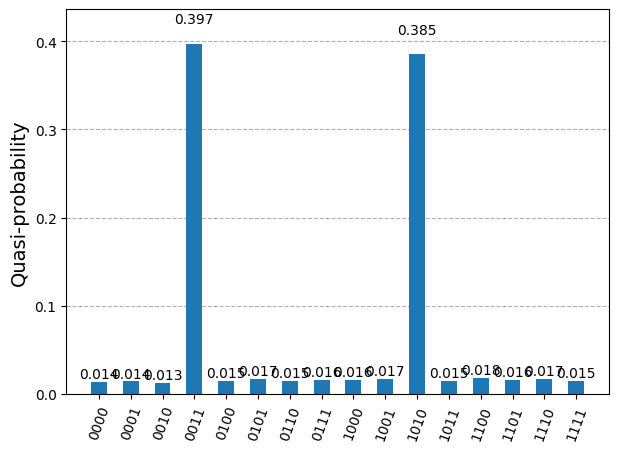

In [78]:
circuit = QuantumCircuit(grover_op.num_qubits)
circuit.h(list(range(grover_op.num_qubits)))
circuit.append(oracle, list(range(grover_op.num_qubits)))
circuit.append(grover_op.power(optimal_num_iterations), list(range(grover_op.num_qubits)))

circuit.measure_all()
circuit.draw(output='mpl', style='iqp')
pm = generate_preset_pass_manager(backend=AerSimulator(), optimization_level=3)

circuit_isa = pm.run(circuit)

sampler = Sampler(backend=AerSimulator())
sampler.options.default_shots = 10_000
result = sampler.run([circuit_isa]).result()
dist = result[0].data.meas.get_counts()

plot_distribution(dist)